In [579]:
import pyvisa as visa
#import visa
import time
import numpy as np
import pymeasure
from pymeasure.instruments.keithley import Keithley2400
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from labview_automation import LabVIEW
from MultiPyVu import MultiVuServer as mvs
from MultiPyVu import MultiVuClient as mvc
        
def measure_resistance(dc, volt, dc_current=100e-6, measure_points=20, skip_points=10, time_per_point=0.02):
    dc.apply_current()  # Sets up to source current
    dc.source_current_range = 10e-3   # Sets the source current range to 10 mA
    dc.compliance_voltage = 10        # Sets the compliance voltage to 10 V
    dc.source_current = dc_current            # Sets the source current to 0 mA
    dc.enable_source() 
    v_up = []
    for i in range(measure_points):  # apply positive current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_up.append(float(volt.query("fetch?")))
    v_up = sorted(v_up)
    v_up = v_up[3: -3]
    # Sets the compliance voltage to 10 V
    dc.source_current = -1 * dc_current
    dc.enable_source() 
    
    v_down = []
    for i in range(measure_points):   # apply negative current
        time.sleep(time_per_point)
        if i < skip_points:
            continue
        v_down.append(float(volt.query("fetch?")))
    
    dc.shutdown() 
    #dc.source_current = dc_current
    #dc.enable_source() 
    
    v_down = sorted(v_down)
    v_down = v_down[3: -3]
    
    average_v = (np.array(v_up).mean() - np.array(v_down).mean())/2
    std_v = (np.array(v_up).std() + np.array(v_down).std())/2
    return average_v, std_v




import subprocess
def get_position():
    result = subprocess.check_output([r'C:\Program Files\IronPython 2.7\ipy.exe', 
                                      r'C:\Users\yanglabuser\Desktop\Sam files\_switch\ppms-master\ppms_position.py'])

    current_p = round(float(result.decode('utf-8').strip().split(',')[1][:-1]))
    return current_p

def set_T(t=300):
    if t < 2 or t > 400:
        raise
    result = subprocess.check_output([r'C:\Program Files\IronPython 2.7\ipy.exe', 
                                      r'C:\Users\yanglabuser\Desktop\Sam files\_switch\ppms-master\ppms.py', str(t)])

    current_t = result.decode('utf-8').strip()
    if abs(float(current_t)-t)<1:
        print("current T {}".format(current_t))
        return
    else:
        print("set t:")
        print(t)
        print("current t:")
        print(current_t)
        raise
        
def set_Field(field=0, persistent=False):
    if abs(field) > 140000:
        raise
    if persistent:
        result = subprocess.check_output([r'C:\Program Files\IronPython 2.7\ipy.exe', 
                                      r'C:\Users\yanglabuser\Desktop\Sam files\_switch\ppms-master\ppms_set_field.py',
                                          str(field), str('persistent')])
    else:
        result = subprocess.check_output([r'C:\Program Files\IronPython 2.7\ipy.exe', 
                                          r'C:\Users\yanglabuser\Desktop\Sam files\_switch\ppms-master\ppms_set_field.py', 
                                          str(field)])

    current_field = result.decode('utf-8').strip()
    print(current_field)
    if abs(float(current_field)-field)<2:
        print("current field {}".format(current_field))
        return
    else:
        print("set field:")
        print(field)
        print("current t:")
        print(current_field)
        raise
        
def trigger_ac(ac, offs=0.005, amp=1e-6, duration=0.005, wait_after_arm=2):
    ac.write("SOUR:WAVE:ABOR")
    ac.write("SOUR:WAVE:OFFS {}".format(offs))
    ac.write("SOUR:WAVE:AMPL {}".format(amp))
    ac.write("SOUR:WAVE:DUR:TIME {}".format(duration))
    ac.write("SOUR:WAVE:ARM")
    time.sleep(wait_after_arm)
    ac.write("SOUR:WAVE:INIT")
    

    
def init_communication(amp=0.00005):
    print("check ac_1: offerset 50uA, amp1uA, duration 10s")
    trigger_ac(ac_1, offs=amp, amp=1e-6, duration=5, wait_after_arm=2)
    time.sleep(15)
    
    print("check ac_2: offerset 50uA, amp1uA, duration 10s")
    trigger_ac(ac_2, offs=amp, amp=1e-6, duration=5, wait_after_arm=2)
    time.sleep(15)
    """
    print("check ac_mid: offerset 50uA, amp1uA, duration 10s")
    trigger_ac(ac_mid, offs=amp, amp=1e-6, duration=5, wait_after_arm=2)
    time.sleep(15)"""
    
    dc.apply_current()# Sets up to source current
    dc.source_current_range = 10e-3   # Sets the source current range to 10 mA
    dc.compliance_voltage = 10        # Sets the compliance voltage to 10 V
    dc.source_current = amp            # Sets the source current to 0.1 mA
    dc.enable_source() 
    print("enable dc current now, current:" + str(dc))
    print("check nano volt:")
    for i in range(10):
        print(volt.query("fetch?"))
        time.sleep(0.1)
    time.sleep(10)
    dc.shutdown()   
    print("dc current disabled")

    
def do_measurement_three_pulses(sample_id='', ac_current=5*1e-3, dc_current=100e-6, duration=0.005, round=6, point_per_round=5,
                                wait_after_trigger=15, pulse=None):
    file_name = "data/{}ac_{}uA{}ms_wait{}s_{}.csv".format(sample_id, int(ac_current * 1e6), 
                                                                     int(duration * 1e3), wait_after_trigger, int(time.time()))
    if not pulse is None:
        file_name = file_name.replace(".csv", "".join(pulse) + ".csv")
    with open(file_name, 'w') as f:
        f.write("round,ac_source,point_count,average_v, std_v, dc_current\n")
        
        
    average_v, std_v = measure_resistance(dc=dc, volt=volt, dc_current=dc_current)
    with open(file_name, 'a') as f:
        f.write("{},{},{},{},{},{}\n".format(0, 'init', 0, average_v, std_v, dc_current))

    for i in range(round):
        print("round: " + str(i+1))
        if pulse is None:
            pulse = ['ac_mid', '-ac_mid', 'ac_2', '-ac_2', 'ac_mid', '-ac_mid', 'ac_1', '-ac_1']
        for current in pulse:
            print("current:" + current)
            for point in range(point_per_round):
                if current == 'ac_1':
                    trigger_ac(ac_1, offs=ac_current, duration=duration)
                elif current == '-ac_1':
                    trigger_ac(ac_1, offs=-1 * ac_current, duration=duration)
                elif current == 'ac_mid':
                    trigger_ac(ac_mid, offs=ac_current, duration=duration)
                elif current == '-ac_mid':
                    trigger_ac(ac_mid, offs=-1 * ac_current, duration=duration)
                elif current == 'ac_2':
                    trigger_ac(ac_2, offs=ac_current, duration=duration)
                elif current == '-ac_2':
                    trigger_ac(ac_2, offs=-1 * ac_current, duration=duration)
                else:
                    print("no ac " + current)
                    raise
                    
                time.sleep(wait_after_trigger)
                average_v, std_v = measure_resistance(dc=dc, volt=volt, dc_current=dc_current)
                with open(file_name, 'a') as f:
                    f.write("{},{},{},{},{},{}\n".format(i, current, point, average_v, std_v, dc_current))
                print(average_v)
                time.sleep(3)
                """
                plt.clf()
                df = pd.read_csv(file_name)
                v = df['average_v']
                v.plot()
                plt.show()"""



def LVread():
    lv = LabVIEW()
    lv.start() # Launches the active LabVIEW with the listener VI
    with lv.client() as c:
        control_values = {
        
            }
    
        indicators = c.run_vi_synchronous(r"D:\User Data\Cheng Yang\Sam files\_switch\test_labview_python\\PPMS_Status_Eckberg.vi", control_values)
    #  print(indicators['Temp (K)'],indicators['Angle'], indicators['Field'] )
    #lv.kill() # Stop LabVIEW
    T=float(indicators['Temp (K)'])
    Ang=float(indicators['Angle'])
    Field=float(indicators['Field'])
    return T, Ang, Field



    
def do_measurement_one_pulse_FM(sample_id='', ac_current=[1*1e-3], dc_current=100e-6, duration=0.001,
                                wait_after_trigger=1, pulse=None):
    file_name = "data/{}ac_{}ms_wait{}s_{}.csv".format(sample_id, 
                                                                     int(duration * 1e3), wait_after_trigger, int(time.time()))
    if not pulse is None:
        file_name = file_name.replace(".csv", "".join(pulse) + ".csv")
    with open(file_name, 'w') as f:
        f.write("current,ac_source,average_v, std_v, dc_current\n")
        
        
    average_v, std_v = measure_resistance(dc=dc, volt=volt, dc_current=dc_current)
    with open(file_name, 'a') as f:
        f.write("{},{},{},{},{}\n".format(0, 'init', average_v, std_v, dc_current))

    for i in ac_current:
        print("pulse current=:{} A".format(i))
        if pulse is None:
            pulse = ['ac_mid', '-ac_mid', 'ac_2', '-ac_2', 'ac_mid', '-ac_mid', 'ac_1', '-ac_1']
        for current in pulse:
            print("current:" + current)
            if current == 'ac_1':
                    trigger_ac(ac_1, offs=i, duration=duration)
            elif current == '-ac_1':
                    trigger_ac(ac_1, offs=-1 * i, duration=duration)
            elif current == 'ac_mid':
                    trigger_ac(ac_mid, offs=i, duration=duration)
            elif current == '-ac_mid':
                    trigger_ac(ac_mid, offs=-1 * i, duration=duration)
            elif current == 'ac_2':
                    trigger_ac(ac_2, offs=i, duration=duration)
            elif current == '-ac_2':
                    trigger_ac(ac_2, offs=-1 * i, duration=duration)
            else:
                    print("no ac " + current)
                    raise
                    
            time.sleep(wait_after_trigger)
            average_v, std_v = measure_resistance(dc=dc, volt=volt, dc_current=dc_current)
            with open(file_name, 'a') as f:
                f.write("{},{},{},{},{}\n".format(i, current, average_v, std_v, dc_current))
            print(average_v)
            time.sleep(0.1)
                
rm = visa.ResourceManager()
rm.list_resources()


('ASRL1::INSTR',
 'GPIB0::15::INSTR',
 'GPIB1::7::INSTR',
 'GPIB1::10::INSTR',
 'GPIB1::12::INSTR',
 'GPIB1::23::INSTR')

In [3]:
#switch
ac_6221_1_id = 12


ac_1 = rm.open_resource('GPIB1::{}::INSTR'.format(ac_6221_1_id))




In [390]:
ac_1.write("SOUR:WAVE:ABOR")
ac_1.write("SOUR:WAVE:RANG FIXED")


22

In [271]:
ac_1.write("SOUR:WAVE:AMPL {}".format(2e-6))


22

In [391]:
ac_1.write("SOUR:WAVE:ARM")
ac_1.write("SOUR:WAVE:INIT")


16

In [388]:
ac_1.write("SOUR:WAVE:AMPL {}".format((1000)*1e-6))    

22

In [396]:
cup=np.arange(2e-6,2e-3,1e-6)   #(start, final, step)
print(cup)

[2.000e-06 3.000e-06 4.000e-06 ... 1.998e-03 1.999e-03 2.000e-03]


In [397]:
#ramp up
for i in cup: 
        time.sleep(2)
        ac_1.write("SOUR:WAVE:AMPL {}".format(i))                  
        print (i*1e3,'mA')
   

0.002 mA
0.003 mA
0.004000000000000001 mA
0.005 mA
0.006 mA
0.007000000000000001 mA
0.008000000000000002 mA
0.009000000000000001 mA
0.01 mA
0.011000000000000001 mA
0.012000000000000002 mA
0.013000000000000001 mA
0.014000000000000002 mA
0.015000000000000003 mA
0.016000000000000004 mA
0.017000000000000005 mA
0.018000000000000002 mA
0.019000000000000003 mA
0.020000000000000004 mA
0.021000000000000005 mA
0.022000000000000006 mA
0.023000000000000003 mA
0.024000000000000004 mA
0.025000000000000005 mA
0.026000000000000006 mA
0.027000000000000007 mA
0.028000000000000008 mA
0.02900000000000001 mA
0.030000000000000006 mA
0.031 mA
0.03200000000000001 mA
0.03300000000000001 mA
0.03400000000000001 mA
0.035 mA
0.036000000000000004 mA
0.037000000000000005 mA
0.038000000000000006 mA
0.03900000000000001 mA
0.04000000000000001 mA
0.04100000000000001 mA
0.04200000000000001 mA
0.04300000000000001 mA
0.044000000000000004 mA
0.04500000000000001 mA
0.046000000000000006 mA
0.047000000000000014 mA
0.0480000000

0.4140000000000001 mA
0.41500000000000004 mA
0.4160000000000001 mA
0.41700000000000004 mA
0.4180000000000001 mA
0.41900000000000004 mA
0.4200000000000001 mA
0.42100000000000004 mA
0.42200000000000004 mA
0.4230000000000001 mA
0.42400000000000004 mA
0.4250000000000001 mA
0.42600000000000005 mA
0.4270000000000001 mA
0.42800000000000005 mA
0.42900000000000005 mA
0.43000000000000005 mA
0.43100000000000005 mA
0.4320000000000001 mA
0.43300000000000005 mA
0.4340000000000001 mA
0.43500000000000005 mA
0.43600000000000005 mA
0.43700000000000006 mA
0.43800000000000006 mA
0.43900000000000006 mA
0.44000000000000006 mA
0.4410000000000001 mA
0.44200000000000006 mA
0.4430000000000001 mA
0.44400000000000006 mA
0.44500000000000006 mA
0.44600000000000006 mA
0.44700000000000006 mA
0.44800000000000006 mA
0.44900000000000007 mA
0.45000000000000007 mA
0.45100000000000007 mA
0.45200000000000007 mA
0.45300000000000007 mA
0.45400000000000007 mA
0.45500000000000007 mA
0.45600000000000007 mA
0.4570000000000001 mA


0.7890000000000003 mA
0.7900000000000003 mA
0.7910000000000001 mA
0.7920000000000001 mA
0.7930000000000001 mA
0.7940000000000003 mA
0.7950000000000002 mA
0.7960000000000002 mA
0.7970000000000002 mA
0.7980000000000002 mA
0.7990000000000003 mA
0.8000000000000002 mA
0.8010000000000002 mA
0.8020000000000002 mA
0.8030000000000003 mA
0.8040000000000002 mA
0.8050000000000002 mA
0.8060000000000002 mA
0.8070000000000002 mA
0.8080000000000003 mA
0.8090000000000002 mA
0.8100000000000002 mA
0.8110000000000002 mA
0.8120000000000003 mA
0.8130000000000002 mA
0.8140000000000002 mA
0.8150000000000002 mA
0.8160000000000002 mA
0.8170000000000003 mA
0.8180000000000002 mA
0.8190000000000002 mA
0.8200000000000002 mA
0.8210000000000002 mA
0.8220000000000002 mA
0.8230000000000002 mA
0.8240000000000002 mA
0.8250000000000002 mA
0.8260000000000003 mA
0.8270000000000002 mA
0.8280000000000002 mA
0.8290000000000002 mA
0.8300000000000002 mA
0.8310000000000002 mA
0.8320000000000002 mA
0.8330000000000002 mA
0.83400000

1.1710000000000003 mA
1.1720000000000004 mA
1.1730000000000003 mA
1.1740000000000004 mA
1.1750000000000003 mA
1.1760000000000002 mA
1.1770000000000003 mA
1.1780000000000002 mA
1.179 mA
1.1800000000000004 mA
1.1810000000000003 mA
1.1820000000000004 mA
1.1830000000000003 mA
1.1840000000000002 mA
1.1850000000000003 mA
1.1860000000000002 mA
1.1870000000000003 mA
1.1880000000000002 mA
1.1890000000000003 mA
1.1900000000000004 mA
1.1910000000000003 mA
1.1920000000000004 mA
1.1930000000000003 mA
1.1940000000000002 mA
1.1950000000000003 mA
1.1960000000000002 mA
1.197 mA
1.1980000000000002 mA
1.1990000000000003 mA
1.2000000000000004 mA
1.2010000000000003 mA
1.2020000000000002 mA
1.2030000000000003 mA
1.2040000000000002 mA
1.2050000000000003 mA
1.2060000000000002 mA
1.207 mA
1.2080000000000004 mA
1.2090000000000003 mA
1.2100000000000004 mA
1.2110000000000003 mA
1.2120000000000002 mA
1.2130000000000003 mA
1.2140000000000002 mA
1.215 mA
1.2160000000000002 mA
1.2170000000000003 mA
1.2180000000000004

1.5530000000000004 mA
1.5540000000000003 mA
1.5550000000000004 mA
1.5560000000000003 mA
1.5570000000000002 mA
1.5580000000000003 mA
1.5590000000000002 mA
1.5600000000000005 mA
1.5610000000000004 mA
1.5620000000000003 mA
1.5630000000000004 mA
1.5640000000000003 mA
1.5650000000000002 mA
1.5660000000000003 mA
1.5670000000000002 mA
1.5680000000000003 mA
1.5690000000000004 mA
1.5700000000000003 mA
1.5710000000000004 mA
1.5720000000000003 mA
1.5730000000000004 mA
1.5740000000000003 mA
1.5750000000000002 mA
1.5760000000000003 mA
1.5770000000000002 mA
1.5780000000000005 mA
1.5790000000000004 mA
1.5800000000000003 mA
1.5810000000000004 mA
1.5820000000000003 mA
1.5830000000000002 mA
1.5840000000000003 mA
1.5850000000000002 mA
1.5860000000000003 mA
1.5870000000000004 mA
1.5880000000000003 mA
1.5890000000000004 mA
1.5900000000000003 mA
1.5910000000000004 mA
1.5920000000000003 mA
1.5930000000000002 mA
1.5940000000000003 mA
1.5950000000000002 mA
1.5960000000000003 mA
1.5970000000000004 mA
1.59800000

1.9260000000000004 mA
1.9270000000000003 mA
1.9280000000000004 mA
1.9290000000000003 mA
1.9300000000000004 mA
1.9310000000000005 mA
1.9320000000000004 mA
1.9330000000000005 mA
1.9340000000000004 mA
1.9350000000000003 mA
1.9360000000000004 mA
1.9370000000000003 mA
1.9380000000000002 mA
1.9390000000000005 mA
1.9400000000000004 mA
1.9410000000000005 mA
1.9420000000000004 mA
1.9430000000000003 mA
1.9440000000000004 mA
1.9450000000000003 mA
1.9460000000000004 mA
1.9470000000000003 mA
1.9480000000000004 mA
1.9490000000000005 mA
1.9500000000000004 mA
1.9510000000000005 mA
1.9520000000000004 mA
1.9530000000000003 mA
1.9540000000000004 mA
1.955 mA
1.9560000000000002 mA
1.957 mA
1.9580000000000002 mA
1.9590000000000003 mA
1.9600000000000004 mA
1.961 mA
1.9620000000000002 mA
1.9630000000000003 mA
1.964 mA
1.965 mA
1.9660000000000002 mA
1.967 mA
1.9680000000000002 mA
1.9690000000000003 mA
1.97 mA
1.971 mA
1.9720000000000002 mA
1.9730000000000003 mA
1.974 mA
1.975 mA
1.9760000000000004 mA
1.977 mA


In [395]:
cdown=np.arange(2e-3,1e-6,-1e-6)   #(start, final, step)
print(cdown)

[2.000e-03 1.999e-03 1.998e-03 ... 4.000e-06 3.000e-06 2.000e-06]


In [389]:
#ramp down
for i in cdown:
        time.sleep(1)
        ac_1.write("SOUR:WAVE:AMPL {}".format(i))                  
        print (c*1e3,'mA')

1.0 mA
0.9989999999999999 mA
0.998 mA
0.9970000000000001 mA
0.9959999999999999 mA
0.995 mA
0.9939999999999999 mA
0.993 mA
0.992 mA
0.9909999999999999 mA
0.99 mA
0.9889999999999999 mA
0.988 mA
0.987 mA
0.9859999999999999 mA
0.985 mA
0.9839999999999999 mA
0.983 mA
0.982 mA
0.9809999999999999 mA
0.98 mA
0.9790000000000001 mA
0.9779999999999999 mA
0.977 mA
0.976 mA
0.975 mA
0.974 mA
0.9729999999999999 mA
0.972 mA
0.971 mA
0.97 mA
0.969 mA
0.968 mA
0.967 mA
0.966 mA
0.965 mA
0.9639999999999999 mA
0.963 mA
0.962 mA
0.961 mA
0.96 mA
0.959 mA
0.958 mA
0.957 mA
0.956 mA
0.9549999999999998 mA
0.954 mA
0.953 mA
0.952 mA
0.951 mA
0.95 mA
0.949 mA
0.948 mA
0.947 mA
0.9460000000000001 mA
0.945 mA
0.944 mA
0.943 mA
0.942 mA
0.941 mA
0.94 mA
0.939 mA
0.938 mA
0.937 mA
0.9359999999999999 mA
0.9349999999999999 mA
0.9339999999999999 mA
0.9329999999999999 mA
0.9319999999999999 mA
0.9309999999999999 mA
0.9299999999999999 mA
0.9289999999999999 mA
0.928 mA
0.9269999999999999 mA
0.9259999999999999 mA
0.924999

0.39 mA
0.38899999999999996 mA
0.388 mA
0.38699999999999996 mA
0.386 mA
0.38499999999999995 mA
0.384 mA
0.383 mA
0.38199999999999995 mA
0.381 mA
0.37999999999999995 mA
0.379 mA
0.37799999999999995 mA
0.377 mA
0.376 mA
0.375 mA
0.374 mA
0.37299999999999994 mA
0.372 mA
0.37099999999999994 mA
0.37 mA
0.369 mA
0.368 mA
0.367 mA
0.366 mA
0.365 mA
0.36399999999999993 mA
0.363 mA
0.362 mA
0.361 mA
0.36 mA
0.359 mA
0.358 mA
0.357 mA
0.356 mA
0.355 mA
0.354 mA
0.353 mA
0.352 mA
0.351 mA
0.35 mA
0.349 mA
0.348 mA
0.347 mA
0.34600000000000003 mA
0.345 mA
0.344 mA
0.34299999999999997 mA
0.34199999999999997 mA
0.34099999999999997 mA
0.33999999999999997 mA
0.339 mA
0.33799999999999997 mA
0.337 mA
0.33599999999999997 mA
0.335 mA
0.33399999999999996 mA
0.33299999999999996 mA
0.332 mA
0.33099999999999996 mA
0.33 mA
0.32899999999999996 mA
0.328 mA
0.32699999999999996 mA
0.326 mA
0.325 mA
0.32399999999999995 mA
0.323 mA
0.32199999999999995 mA
0.321 mA
0.31999999999999995 mA
0.319 mA
0.318 mA
0.317 mA
0.3

In [31]:
sensitivity = {1:26, 0.5:25, 0.2:24, 0.1:23, 0.05:22, 0.02:21, 0.01:20, 0.005:19, 0.002:18, 0.001:17, 0.0005:16, 0.0002:15,
               0.0001:14, 0.00005:13, 0.00002:12, 0.00001:11, 0.000005:10, 0.000002:9, 0.000001:8, 0.0000005:7, 0.0000002:6, 0.0000001:5, 0.00000005:4, 0.00000002:3,
               0.00000001:2, 0.000000005:1, 0.000000002:0}


class Lockin:
    def __init__(self, resource, gpib=1):
        self.lock_in = resource.open_resource('GPIB1::{}::INSTR'.format(gpib))

    def change_harmonic(self, harm=1, sens=1):

       
        self.lock_in.write("HARM {}".format(harm))
        self.lock_in.write("SENS {}".format(sensitivity[sens]))

    def lock_in_read(self):
        x = float(self.lock_in.query("OUTP? 1").strip())
        y = float(self.lock_in.query("OUTP? 2").strip())
        r = float(self.lock_in.query("OUTP? 3").strip())
        theta = float(self.lock_in.query("OUTP? 4").strip())
        return x, y, r, theta

    def lock_in_measure(self, count=10, time_step=0.1,
                        wait_before_measure=1,
                        harm=1, sens=0.00001):
#        self.change_harmonic(harm, sens)
        time.sleep(wait_before_measure)
        xs, ys, rs, thetas = [], [], [], []
        for i in range(count):
            x, y, r, theta = self.lock_in_read()
            xs += [x]
            ys += [y]
            rs += [r]
            thetas += [theta]
            time.sleep(time_step)
            
        xs = sorted(xs)
        ys=  sorted(ys)
        rs=  sorted(rs)
        thetas=sorted(thetas)
        
        if len(xs)>30:
            xs = xs[round(1/6*len(xs)): -round(1/6*len(xs))]
            ys = ys[round(1/6*len(ys)): -round(1/6*len(ys))]
            rs = rs[round(1/6*len(rs)): -round(1/6*len(rs))]
            thetas = thetas[round(1/6*len(thetas)): -round(1/6*len(thetas))]

        x_mean, x_std = np.mean(xs), np.std(xs)
        y_mean, y_std = np.mean(ys), np.std(ys)
        r_mean, r_std = np.mean(rs), np.std(rs)
        theta_mean, theta_std = np.mean(thetas), np.std(thetas)
        
        
        return x_mean, y_mean, r_mean, theta_mean, \
               x_std, y_std,r_std, theta_std

In [32]:


lock1 = Lockin(rm, 7)
#lock2 = Lockin(rm, 8)
lock3 = Lockin(rm, 10)
#lock4 = Lockin(rm, 11)

In [548]:
print(lock1.lock_in_measure(count=100, time_step=0.1, wait_before_measure=0.1))
#print(lock2.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.1))
print(lock3.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.1))
#print(lock4.lock_in_measure(count=1, time_step=0.1, wait_before_measure=0.1))

(0.0010050065757575756, 0.04698851363636363, 0.0469988106060606, 88.77154545454545, 1.9248129902912967e-05, 8.238946844724337e-05, 8.19027067462363e-05, 0.02544106786053499)
(-2.16068e-05, -0.000143797, 0.000145406, -98.544, 0.0, 0.0, 0.0, 0.0)


In [551]:
lock1.change_harmonic(harm=1, sens=1)
lock3.change_harmonic(harm=1, sens=0.01)

In [547]:
lock1.change_harmonic(harm=2, sens=1e-1)
lock3.change_harmonic(harm=2, sens=5e-4)

In [492]:
lock1.change_harmonic(harm=3, sens=1e-1)
lock3.change_harmonic(harm=3, sens=2e-2)

In [416]:
field=90000
T=200
current=2e-3
file_name = "data/BST_{}Oe_{}K_{}.csv".format(field, T, int(time.time()))
with open(file_name, 'w') as f:
        f.write("Field,Ang,x11,y11,x12,y12,x13,y13,x21,y21,x22,y22,x23,y23,current\n")

In [567]:
Ang=370
print('Ang={} deg'.format(Ang))
flag=True

Ang=370 deg


In [568]:
while flag:
    
    time.sleep(20)
    A1=lock1.lock_in_measure(count=10, time_step=0.1, wait_before_measure=0)
    C1=lock3.lock_in_measure(count=10, time_step=0.1, wait_before_measure=0)

    lock1.change_harmonic(harm=2, sens=1e-1)
    lock3.change_harmonic(harm=2, sens=5e-4)
    time.sleep(35)
    A2=lock1.lock_in_measure(count=80, time_step=0.1, wait_before_measure=0)
    C2=lock3.lock_in_measure(count=80, time_step=0.1, wait_before_measure=0)

    lock1.change_harmonic(harm=3, sens=1e-1)
    lock3.change_harmonic(harm=3, sens=2e-2)
    time.sleep(35)
    A3=lock1.lock_in_measure(count=80, time_step=0.1, wait_before_measure=0)
    C3=lock3.lock_in_measure(count=80, time_step=0.1, wait_before_measure=0)

    lock1.change_harmonic(harm=1, sens=1)
    lock3.change_harmonic(harm=1, sens=0.01)

    with open(file_name, 'a') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(field, Ang, A1[0], A1[1], A2[0],A2[1],A3[0], A3[1],C1[0], C1[1],C2[0], C2[1],C3[0], C3[1], current))
    flag=False
    
    print('done,Ang={} deg'.format(Ang) )

done,Ang=370 deg


<Figure size 432x288 with 0 Axes>

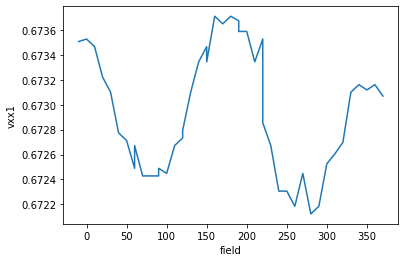

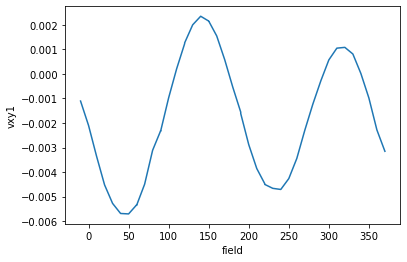

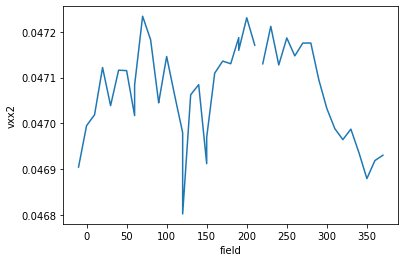

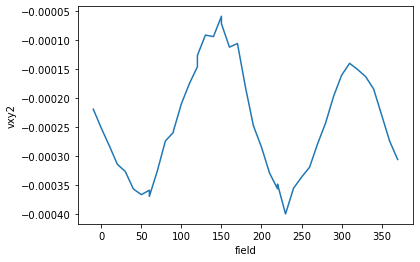

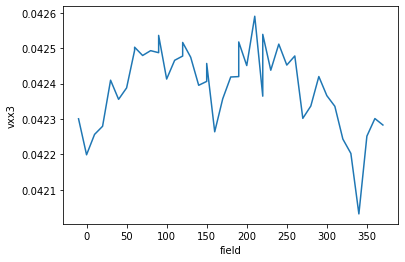

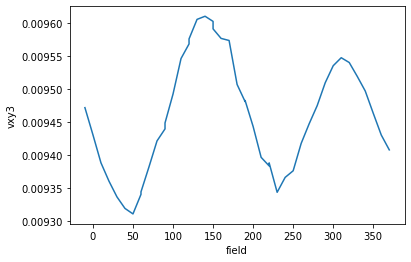

In [569]:
plt.clf()
file_name = "D:/User Data/Cheng Yang/Sam files/_switch/data/BST_90000Oe_200K_1670565426.csv"
df = pd.read_csv(file_name);df.columns = df.columns.str.strip();

vxx1 = df['x11'];vxy1 = df['x21'];vxx2 = df['y12'];vxy2 = df['y22'];vxx3 = df['x13'];vxy3 = df['x23'];f= df['Ang']

plt.figure();plt.xlabel('field');plt.ylabel('vxx1');plt.plot(f,vxx1);plt.show();
plt.figure();plt.xlabel('field');plt.ylabel('vxy1');plt.plot(f,vxy1);plt.show();
plt.figure();plt.xlabel('field');plt.ylabel('vxx2');plt.plot(f,vxx2);plt.show();
plt.figure();plt.xlabel('field');plt.ylabel('vxy2');plt.plot(f,vxy2);plt.show();
plt.figure();plt.xlabel('field');plt.ylabel('vxx3');plt.plot(f,vxx3);plt.show();
plt.figure();plt.xlabel('field');plt.ylabel('vxy3');plt.plot(f,vxy3);plt.show();

In [256]:
def SetField(Field=200, rate=100, Mode='persistent'):
    with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:
            if Mode=='persistent':
                client.set_field(Field,
                         rate, 
                         client.field.approach_mode.no_overshoot,
                         client.field.driven_mode.persistent)
            elif  Mode=='driven':
                client.set_field(Field,
                         rate, 
                         client.field.approach_mode.no_overshoot,
                         client.field.driven_mode.driven)
            else:
                print("wrong mode")
                
                
def GetField():
    with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:
    
            Field, sF = client.get_field()
        
    return Field, sF 


def SetTemp(Temp=2, rate=10, Mode='fast_settle'):
    with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:
            if Mode=='fast_settle':
                client.set_temperature(Temp,
                         rate, 
                         client.temperature.approach_mode.fast_settle)
            elif  Mode=='no_overshoot':
                 client.set_temperature(Temp,
                         rate, 
                         client.temperature.approach_mode.no_overshoot)
            else:
                print("wrong mode")
def GetTemp():
    with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:
    
            Temp, sT = client.get_temperature()
        
    return Temp, sT


def SetTempStable(Temp=2, rate=10, Mode='fast_settle'):
    with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:
            if Mode=='fast_settle':
                client.set_temperature(Temp,
                         rate, 
                         client.temperature.approach_mode.fast_settle)
            elif  Mode=='no_overshoot':
                 client.set_temperature(Temp,
                         rate, 
                         client.temperature.approach_mode.no_overshoot)
            else:
                print("wrong mode")
            
            
            Flg = 1
            while  Flg:
                time.sleep(60)
                T = client.get_temperature()
                if abs(T[0] - Temp)<0.1:
                    Flg = 0
            
            time.sleep(600)
            
            Flg = 1
            while  Flg:
                time.sleep(60)
                T = client.get_temperature()
                if abs(T[0] - Temp)<0.1:
                    print('Temp is {}'.format(Temp))
                    Flg = 0
                    
def SetFieldStable(Field=200, rate=100, Mode='driven'):
     with mvs.MultiVuServer() as server:

    # Start the client
        with mvc.MultiVuClient() as client:
            if Mode=='persistent':
                client.set_field(Field,
                         rate, 
                         client.field.approach_mode.no_overshoot,
                         client.field.driven_mode.persistent)
            elif  Mode=='driven':
                client.set_field(Field,
                         rate, 
                         client.field.approach_mode.no_overshoot,
                         client.field.driven_mode.driven)
            else:
                print("wrong mode")
                  
            Flg = 1
            while Flg:
                F = client.get_field()
                if abs(F[0]-Field) < 1:
                    Flg = 0
            print("field is stable = {}Oe".format(Field))


In [575]:
Fields=np.append(np.arange(-90000,90000,5000),np.arange(90000,-95000,-5000))   #(start, final, step)
Fields=np.append(Fields,np.arange(-90000,5000,5000))
print(Fields)


[-90000 -85000 -80000 -75000 -70000 -65000 -60000 -55000 -50000 -45000
 -40000 -35000 -30000 -25000 -20000 -15000 -10000  -5000      0   5000
  10000  15000  20000  25000  30000  35000  40000  45000  50000  55000
  60000  65000  70000  75000  80000  85000  90000  85000  80000  75000
  70000  65000  60000  55000  50000  45000  40000  35000  30000  25000
  20000  15000  10000   5000      0  -5000 -10000 -15000 -20000 -25000
 -30000 -35000 -40000 -45000 -50000 -55000 -60000 -65000 -70000 -75000
 -80000 -85000 -90000 -90000 -85000 -80000 -75000 -70000 -65000 -60000
 -55000 -50000 -45000 -40000 -35000 -30000 -25000 -20000 -15000 -10000
  -5000      0]


In [576]:
cdown=np.arange(2e-3,1e-6,-1e-6)   #(start, final, step)
print(cdown)

[2.000e-03 1.999e-03 1.998e-03 ... 4.000e-06 3.000e-06 2.000e-06]


In [577]:
T=200
current=2e-3
Ang=90
Fields=np.append(np.arange(-90000,90000,5000),np.arange(90000,-95000,-5000))   #(start, final, step)
Fields=np.append(Fields,np.arange(-90000,5000,5000))
file_name = "data/BST_{}K_{}.csv".format(T, int(time.time()))
with open(file_name, 'w') as f:
        f.write("Field,Ang,x11,y11,x12,y12,x13,y13,x21,y21,x22,y22,x23,y23,current\n")

for F in Fields:  
    SetFieldStable(Field=F, rate=100, Mode='driven')
    
    A1=lock1.lock_in_measure(count=3, time_step=0.1, wait_before_measure=0)
    C1=lock3.lock_in_measure(count=3, time_step=0.1, wait_before_measure=0)

    lock1.change_harmonic(harm=2, sens=1e-1)
    lock3.change_harmonic(harm=2, sens=5e-4)
    time.sleep(35)
    A2=lock1.lock_in_measure(count=80, time_step=0.1, wait_before_measure=0)
    C2=lock3.lock_in_measure(count=80, time_step=0.1, wait_before_measure=0)

    lock1.change_harmonic(harm=3, sens=1e-1)
    lock3.change_harmonic(harm=3, sens=2e-2)
    time.sleep(35)
    A3=lock1.lock_in_measure(count=80, time_step=0.1, wait_before_measure=0)
    C3=lock3.lock_in_measure(count=80, time_step=0.1, wait_before_measure=0)

    lock1.change_harmonic(harm=1, sens=1)
    lock3.change_harmonic(harm=1, sens=0.01)

    with open(file_name, 'a') as f:
            f.write("{},{},{},{},{},{},{},{},{},{},{},{},{},{},{}\n".format(F, Ang, A1[0], A1[1], A2[0],A2[1],A3[0], A3[1],C1[0], C1[1],C2[0], C2[1],C3[0], C3[1], current))

cdown=np.arange(2e-3,1e-6,-1e-6)   #(start, final, step)
print(cdown)
#ramp down
for i in cdown:
        time.sleep(1)
        ac_1.write("SOUR:WAVE:AMPL {}".format(i))                  
        print (i*1e3,'mA')
ac_1.write("SOUR:WAVE:ABOR")
ac_1.write("SOUR:WAVE:RANG FIXED")
SetTemp(Temp=300, rate=10)


MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56793)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56793)
MultiVuServer - Client ('127.0.0.1', 56793) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56793)


field is stable = -90000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56793)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56799)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56799)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -85000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56799)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56821)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56821)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -80000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56821)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56836)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56836)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -75000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56836)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56855)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56855)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -70000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56855)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56862)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56862)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 56862) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56862)


field is stable = -65000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56862)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56882)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56882)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -60000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56882)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56894)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56894)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 56894) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56894)


field is stable = -55000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56894)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56913)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56913)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -50000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56913)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56924)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56924)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 56924) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56924)


field is stable = -45000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56924)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56944)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56944)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 56944) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56944)


field is stable = -40000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56944)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56957)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56957)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -35000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56957)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56975)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56975)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 56975) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56975)


field is stable = -30000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56975)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56983)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56983)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 56983) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56983)


field is stable = -25000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56983)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57004)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57004)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 57004) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 57004)


field is stable = -20000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57004)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57018)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57018)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -15000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57018)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57035)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57035)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

field is stable = -10000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57035)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57046)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57046)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 57046) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 57046)


field is stable = -5000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57046)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57064)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57064)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 0Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57064)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57080)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57080)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 5000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57080)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57096)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57096)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 10000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57096)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57112)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57112)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 57112) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 57112)


field is stable = 15000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57112)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57128)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57128)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 20000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57128)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57148)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57148)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 25000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57148)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57158)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57158)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C

field is stable = 30000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57158)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57178)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57178)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 57178) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 57178)


field is stable = 35000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57178)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57190)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57190)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 57190) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 57190)


field is stable = 40000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57190)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 57221)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 57221)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 57221) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 57221)


field is stable = 45000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 57221)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55362)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55362)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 50000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55362)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55384)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55384)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 55000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55384)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55396)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55396)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 60000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55396)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55410)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55410)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55410) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55410)


field is stable = 65000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55410)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55425)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55425)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\ProgramData\Anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C

field is stable = 70000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55425)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55443)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55443)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 75000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55443)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55456)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55456)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 80000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55456)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55473)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55473)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 85000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55473)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55489)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55489)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 90000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55489)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55508)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55508)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 85000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55508)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55522)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55522)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55522) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55522)


field is stable = 80000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55522)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55540)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55540)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55540) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55540)


field is stable = 75000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55540)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55557)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55557)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55557) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55557)


field is stable = 70000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55557)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55575)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55575)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 65000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55575)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55587)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55587)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 60000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55587)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55604)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55604)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 55000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55604)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55618)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55618)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55618) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55618)


field is stable = 50000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55618)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55637)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55637)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55637) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55637)


field is stable = 45000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55637)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55647)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55647)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 40000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55647)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55667)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55667)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55667) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55667)


field is stable = 35000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55667)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55679)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55679)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55679) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55679)


field is stable = 30000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55679)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55705)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55705)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 25000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55705)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55717)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55717)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 20000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55717)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55737)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55737)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 15000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55737)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55750)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55750)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55750) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55750)


field is stable = 10000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55750)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55768)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55768)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55768) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55768)


field is stable = 5000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55768)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55776)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55776)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 0Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55776)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55798)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55798)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -5000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55798)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55812)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55812)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -10000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55812)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55830)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55830)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55830) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55830)


field is stable = -15000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55830)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55840)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55840)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -20000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55840)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55861)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55861)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -25000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55861)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55876)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55876)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -30000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55876)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55894)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55894)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -35000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55894)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55902)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55902)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -40000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55902)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55926)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55926)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -45000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55926)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55938)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55938)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -50000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55938)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55953)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55953)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55953) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55953)


field is stable = -55000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55953)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55969)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55969)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 55969) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 55969)


field is stable = -60000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55969)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 55981)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 55981)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -65000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 55981)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56014)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56014)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -70000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56014)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56023)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56023)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 56023) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56023)


field is stable = -75000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56023)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56046)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56046)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -80000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56046)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56058)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56058)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -85000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56058)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56082)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56082)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -90000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56082)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56092)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56092)
MultiVuServer - Client ('127.0.0.1', 56092) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56092)


field is stable = -90000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56092)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56109)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56109)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -85000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56109)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56122)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56122)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -80000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56122)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56139)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56139)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -75000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56139)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56154)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56154)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -70000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56154)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56175)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56175)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -65000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56175)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56187)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56187)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -60000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56187)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56208)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56208)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 56208) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56208)


field is stable = -55000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56208)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56231)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56231)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -50000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56231)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56249)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56249)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -45000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56249)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56258)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56258)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

field is stable = -40000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56258)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56282)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56282)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 56282) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56282)


field is stable = -35000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56282)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56296)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56296)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -30000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56296)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56314)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56314)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -25000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56314)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56322)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56322)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = -20000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56322)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56341)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56341)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 56341) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56341)


field is stable = -15000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56341)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56353)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56353)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

MultiVuServer - Client ('127.0.0.1', 56353) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 56353)


field is stable = -10000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56353)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56374)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56374)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
Call stack:
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 890, in _bootstrap
    self._bootstrap_inner()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 932, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-pac

field is stable = -5000Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56374)
MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)
MultiVuServer - Accepted connection from ('127.0.0.1', 56382)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 56382)
--- Logging error ---
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 70, in emit
    self.doRollover()
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 171, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\ProgramData\Anaconda3\lib\logging\handlers.py", line 111, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log' -> 'D:\\User Data\\Cheng Yang\\Sam files\\_switch\\QdMultiVu.log.1'
C

field is stable = 0Oe


MultiVuServer - Closing connection to ('127.0.0.1', 56382)


[2.000e-03 1.999e-03 1.998e-03 ... 4.000e-06 3.000e-06 2.000e-06]
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999

[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.0

[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.0

[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.0

[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.0

[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.0

[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.0

[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.0

[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.0

[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.0

[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA
[0.002 0.0

MultiVuServer - Found PPMS running.
MultiVuServer - listening on ('localhost', 5000)
MultiVuServer - Press ESC to exit.
MultiVuClient - Starting connection to ('localhost', 5000)


[0.002 0.003 0.004 ... 1.998 1.999 2.   ] mA


MultiVuServer - Accepted connection from ('127.0.0.1', 64979)
MultiVuClient - Connected to PPMS MultiVuServer at ('127.0.0.1', 64979)
MultiVuServer - Client ('127.0.0.1', 64979) disconnected.
MultiVuClient - Closing connection to ('127.0.0.1', 64979)
MultiVuServer - Closing connection to ('127.0.0.1', 64979)
